# Time to coalescence

If we sample two alleles at a point locus and follow their lineages back in time through the generations, at any point in time they must be in one of three states:

* SEPARATED - the two lineages are in different hosts
* COTRANSMITTED - the two lineages are in the same host
* COALESCED

With the genomic transmission graph, we can work out a [matrix of transition probabilities between these three states](https://d-kwiat.github.io/gtg/transition-probability.html).  Using this we can perform a Markov chain simulation that gives us the probability distribution of time to coalescence.

We can use the [`get_coalescent` function in `coalestr`](https://d-kwiat.github.io/gtg/get-coalescent.html) to get the probability distribution of coalescence time by Markov chain simulation.  However here we will work through the calculations from scratch to see the various steps involved. 

We start by specifying the transmission parameters and the duration of the simulation
* `N` is the effective number of hosts
* `X` is the crossing rate of transmission chains
* `Q` is the quantum of transmission
* `t_sim` is the duration of the simulation in generations

We use the transmission parameters to construct a matrix of transition probabilities called `transition_matrix`.

We create arrays to record the state of two lineages as we progress back in time
* `beho_lineage` and `wiho_lineage` are two-dimensional arrays that record a probability vector [Pr{SEPARATED}, Pr{COTRANSMITTED}, Pr{COALESCED}] for each time point.
* `beho_lineage` studies *between-host variation* so we specify that Pr{SEPARATED} = 1 at the start of the simulation, i.e. we sample two alleles from different hosts.
* `wiho_lineage` studies *within-host variation* so we specify that Pr{COTRANSMITTED} = 1 at the start of the simulation, i.e. we sample two alleles from the same host.

We work out the probability vector for each successive time point by matrix multiplication then we plot the results.

We create an array called `tcdist` that records the probability of coalescence occurring at each time point, and from this we can calculate the mean time to coalescence.

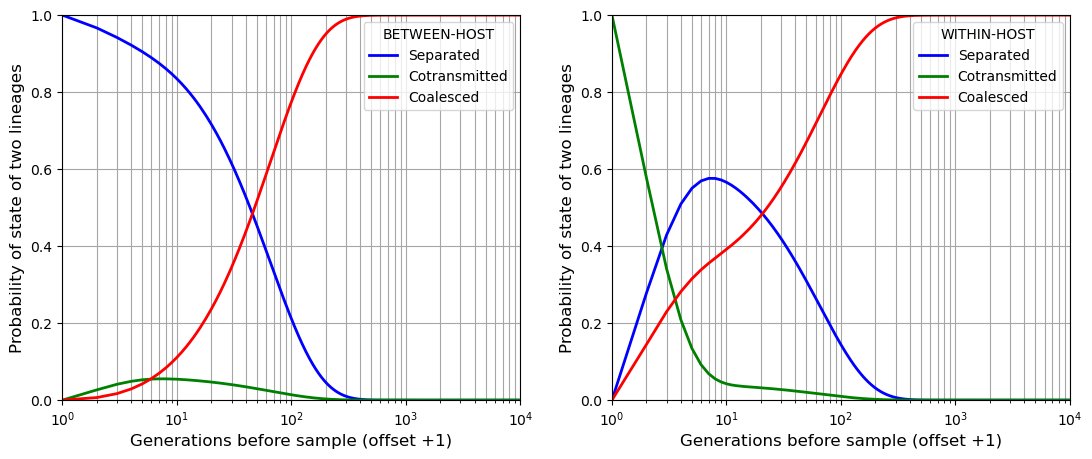

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# SPECIFY THE TRANSMISSION PARAMETERS

N = 30  # Effective number of hosts.
X = 0.5 # Crossing rate of transmission chains
Q = 5   # Quantum of transmission.

# SPECIFY THE DURATION OF THE SIMULATION IN GENERATIONS

t_sim = 10000

# CREATE A MATRIX OF TRANSITION PROBABILITIES

transition_matrix = np.ones((3,3))

transition_matrix[0,:] = [1 - (1 / N), 
                   (Q - 1) / (N * Q),
                    1 / (N * Q)]

transition_matrix[1,:] = [Q * X / (2*Q - 1),
                  (Q - 1) * (2*Q - Q*X - 1) / (Q * (2*Q - 1)), 
                  (2*Q - Q*X - 1) / (Q * (2*Q - 1))]

transition_matrix[2,:] = [0, 0, 1]

# CREATE ARRAYS TO TRACK THE STATE OF TWO LINEAGES AS WE PROGRESS BACK IN TIME

beho_lineage = np.zeros((t_sim + 1, 3)) # an array for analysing between-host variation

wiho_lineage = np.zeros((t_sim + 1, 3))  # an array for analysing within-host variation 

    # [t,0] Pr{Separated} at time t
    # [t,1] Pr{Cotransmitted}
    # [t,2] Pr{Coalesced}
    
# To study between-host variation we specify that at t=0 the lineages are separated

beho_lineage[0,:] = [1, 0, 0]

# To study within-host variation we specify that at t=0 the lineages are cotransmitted

wiho_lineage[0,:] = [0, 1, 0]
    
# PERFORM THE SIMULATION BY MATRIX MULTIPLICATION

for t in range(1, t_sim + 1):

    beho_lineage[t,:] = np.matmul(beho_lineage[t-1,:], transition_matrix[:,:])
    
    wiho_lineage[t,:] = np.matmul(wiho_lineage[t-1,:], transition_matrix[:,:])
    
# DISPLAY THE PROBABILITY OF EACH STATE OVER TIME

# To allow log scale for time we offset the horizontal axis by +1.  Thus t=1 is the time of sampling alleles.

plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
plt.plot(range(1,t_sim + 2), beho_lineage[:,0], marker='', color='blue', linewidth=2, label="Separated")
plt.plot(range(1,t_sim + 2), beho_lineage[:,1], marker='', color='green', linewidth=2, label="Cotransmitted")
plt.plot(range(1,t_sim + 2), beho_lineage[:,2], marker='', color='red', linewidth=2, label="Coalesced")
plt.xlabel("Generations before sample (offset +1)", fontsize=12)
plt.ylabel("Probability of state of two lineages", fontsize=12)
plt.xscale('log')
plt.grid(visible=True, which='both', color='0.65', linestyle='-')
plt.axis([1, t_sim, 0, 1])
plt.legend(title="BETWEEN-HOST", frameon=True) # can add (title="Title", frameon=False) 

plt.subplot(1,2,2)
plt.plot(range(1,t_sim + 2), wiho_lineage[:,0], marker='', color='blue', linewidth=2, label="Separated")
plt.plot(range(1,t_sim + 2), wiho_lineage[:,1], marker='', color='green', linewidth=2, label="Cotransmitted")
plt.plot(range(1,t_sim + 2), wiho_lineage[:,2], marker='', color='red', linewidth=2, label="Coalesced")
plt.xlabel("Generations before sample (offset +1)", fontsize=12)
plt.ylabel("Probability of state of two lineages", fontsize=12)
plt.xscale('log')
plt.grid(visible=True, which='both', color='0.65', linestyle='-')
plt.axis([1, t_sim, 0, 1])
plt.legend(title="WITHIN-HOST", frameon=True) # can add (title="Title", frameon=False) 

plt.show()

In the following cell we perform exactly the same calculation of time to coalescence [using the `get_coalescent` function](https://d-kwiat.github.io/gtg/get-coalescent.html) within the `coalestr` package.

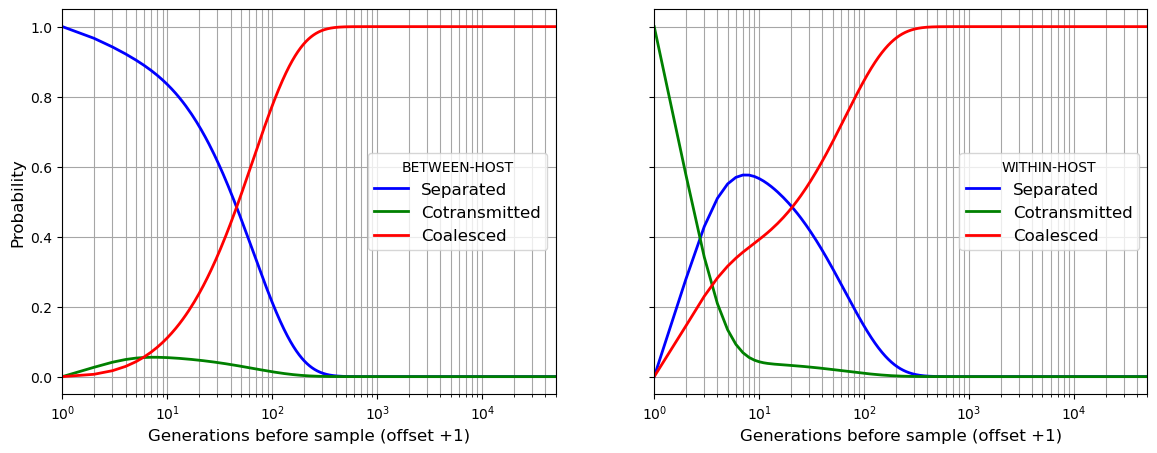

In [7]:
!pip install coalestr

from coalestr import cs
import matplotlib.pyplot as plt

N = 30       # Effective number of hosts
Q = 5        # Quantum of transmission
X = 0.5      # Crossing rate of transmission chains
duration = 50000

history = [[duration, N, Q, X, 0]]
my_village = cs.Population(history)
my_village.get_coalescent(show = False)

b_separated = my_village.beho_lineage[:, 0]
b_cotransmitted = my_village.beho_lineage[:, 1]
b_coalesced = my_village.beho_lineage[:, 2]

w_separated = my_village.wiho_lineage[:, 0]
w_cotransmitted = my_village.wiho_lineage[:, 1]
w_coalesced = my_village.wiho_lineage[:, 2]

# in this figure the time axis has a log scale
# .. which requires that we offset the axis by 1
# .. so we pretend that alleles are sampled at bt = 1

timescale = range(1, my_village.t_his + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5), sharex = True, sharey = True)

ax1.plot(timescale, b_separated, marker='', color='blue', linewidth = 2, label="Separated")
ax1.plot(timescale, b_cotransmitted, marker='', color='green', linewidth = 2, label="Cotransmitted")
ax1.plot(timescale, b_coalesced, marker='', color='red', linewidth = 2, label="Coalesced")

ax2.plot(timescale, w_separated, marker='', color='blue', linewidth = 2, label="Separated")
ax2.plot(timescale, w_cotransmitted, marker='', color='green', linewidth = 2, label="Cotransmitted")
ax2.plot(timescale, w_coalesced, marker='', color='red', linewidth = 2, label="Coalesced")

ax1.legend(title="BETWEEN-HOST",frameon=True, fontsize=12)
ax2.legend(title="WITHIN-HOST",frameon=True, fontsize=12)
ax1.set_xlabel("Generations before sample (offset +1)", fontsize=12)
ax2.set_xlabel("Generations before sample (offset +1)", fontsize=12)
ax1.set_ylabel("Probability", fontsize=12)
ax1.set_xscale('log',base=10)
ax1.set_xlim(1,my_village.t_his)
ax1.grid(visible=True, which='both', color='0.65', linestyle='-')
ax2.grid(visible=True, which='both', color='0.65', linestyle='-')

plt.show()

In the cell below we plot the probability distribution of coalescence time for three different populations:

* $N_h = 100, Q = 1, \chi = 0$

* $N_h = 100, Q = 2, \chi = 0.5$

* $N_h = 100, Q = 10, \chi = 1$

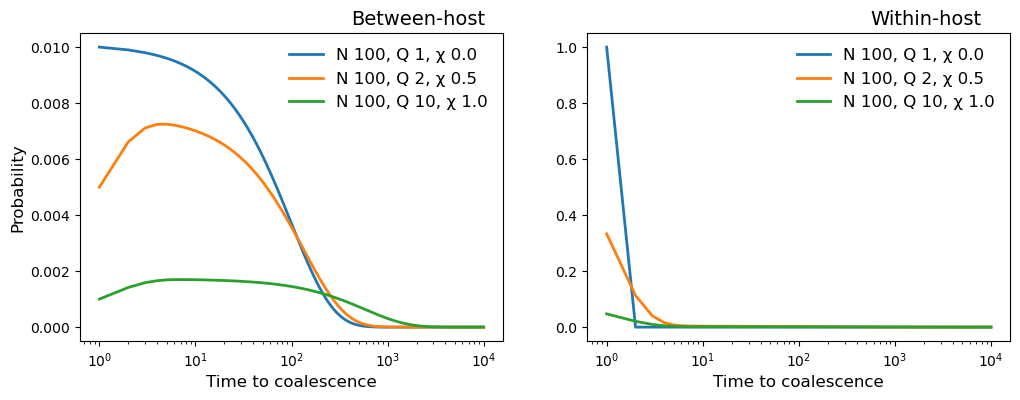

In [9]:
# Nh = 100, Q = 1, X = 0

history_1 = [[10000, 100, 1, 0, 0]] 
pop_1 = cs.Population(history_1)
pop_1.get_coalescent(show = False)

# Nh = 100, Q = 2, X = 0.5

history_2 = [[10000, 100, 2, 0.5, 0]]
pop_2 = cs.Population(history_2)
pop_2.get_coalescent(show = False)

# Nh = 100, Q = 10, X = 1

history_3 = [[10000, 100, 10, 1, 0]]
pop_3 = cs.Population(history_3)
pop_3.get_coalescent(show = False)

ig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4), sharex = True)

for example in [pop_1, pop_2, pop_3]:
    
    N = example.parameters[0,0]
    Q = example.parameters[0,1]
    X = example.parameters[0,2]
    
    timescale = range(1, example.t_his)
    beho_coalescent = example.coalescent[0, 1:, 0]
    wiho_coalescent = example.coalescent[0, 1:, 1]

    ax1.plot(timescale, beho_coalescent, marker='', linewidth=2, label=
        "N {0:.0f}, Q {1:.0f}, \u03C7 {2:.1f}".format(N, Q, X))
    
    ax2.plot(timescale, wiho_coalescent, marker='', linewidth=2, label=
        "N {0:.0f}, Q {1:.0f}, \u03C7 {2:.1f}".format(N, Q, X))
    
ax1.set_title("Between-host", position=(0.8, 0.3), fontsize=14)
ax2.set_title("Within-host", position=(0.8, 0.3), fontsize=14)
ax1.set_xlabel("Time to coalescence", fontsize=12)
ax2.set_xlabel("Time to coalescence", fontsize=12)
ax1.set_ylabel("Probability", fontsize=12)
ax1.set_xscale('log',base=10)
ax1.legend(frameon=False, fontsize=12)
ax2.legend(frameon=False, fontsize=12)

plt.show()